In [2]:
%load_ext autoreload
%autoreload 2

# Move up a directory (until the root of the git repo),
# but only if this has not been done before.
if 'in_correct_dir' not in locals():
    # type: ignore
    %cd -q ..
in_correct_dir = True
%pwd

'/home/wout/pp/code'

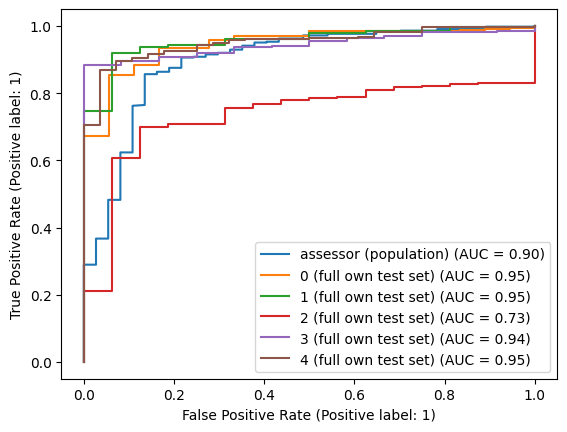

In [21]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import assessors.report as rr

df = pd.read_csv("artifacts/results/segment_default_k5_wln20/results.csv")
df_system = pd.read_csv("artifacts/results/segment_default_k5_wln20/system_results.csv")
# df = pd.read_csv("artifacts/results/cifar10_default_k5_unweight/results.csv")
# df = pd.read_csv("results.csv")

df = rr.wrap.as_classification_with_binary_reward(df)
df_system.syst_prediction = df_system.syst_prediction.map(lambda s: np.array(json.loads(s)))

roc = metrics.RocCurveDisplay.from_predictions(
    name="assessor (population)",
    y_true=df.syst_pred_score,
    y_pred=df.asss_prediction,
)
for syst_id in sorted(df.syst_features.unique()):
    selected = df_system.loc[df_system.syst_features == syst_id]
    metrics.RocCurveDisplay.from_predictions(
        name=f"{syst_id[1]} (full own test set)",
        y_true=selected.syst_pred_score,
        y_pred=selected.syst_prediction.map(lambda p: np.max(p, axis=1)[0]),
        ax=roc.ax_,
    )
# roc_system = metrics.RocCurveDisplay.from_predictions(
#     name="population",
#     y_true=df.syst_pred_score,
#     y_pred=df.syst_prediction.map(lambda p: np.max(p, axis=1)[0]),
#     ax=roc.ax_,
# )
roc

In [4]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import assessors.report as rr

df = pd.read_csv("artifacts/results/segment_default_k5_wln20/results.csv")
df_system = pd.read_csv("artifacts/results/segment_default_k5_wln20/system_results.csv")
df = rr.wrap.as_classification_with_binary_reward(df)
df_system.syst_prediction = df_system.syst_prediction.map(lambda s: np.array(json.loads(s)))

systems = sorted(df.syst_id.unique())
per_system = [df.loc[df.syst_id == system] for system in systems]
per_system2 = [df_system.loc[df_system.id == system] for system in systems]

conf = lambda pred: np.max(pred, axis=1)[0]

brier = pd.DataFrame()
brier['system_id'] = systems
brier['assessor'] = [metrics.brier_score_loss(df.syst_pred_score, df.asss_prediction)
                     for df in per_system]
brier['system'] = [metrics.brier_score_loss(df.syst_pred_score, df.syst_prediction.map(conf))
                   for df in per_system2]
brier['baseline_no_refinement'] = [metrics.brier_score_loss(
    df.syst_pred_score,
    len(df) * [df.syst_pred_score.mean()])
    for df in per_system2]

brier = brier.append({
    'system_id': 'all',
    'system': metrics.brier_score_loss(df_system.syst_pred_score, df_system.syst_prediction.map(conf)),
    'assessor': metrics.brier_score_loss(df.syst_pred_score, df.asss_prediction),
    'baseline_no_refinement': metrics.brier_score_loss(
        df_system.syst_pred_score, len(df_system) * [df_system.syst_pred_score.mean()])
}, ignore_index=True)

brier

,system_id,assessor,system,baseline_no_refinement
0,"[0, 0]",0.059870,0.035984,0.046282
1,"[1, 0]",0.052843,0.030098,0.041373
2,"[2, 0]",0.061672,0.081143,0.041373
3,"[3, 0]",0.022737,0.030375,0.031463
4,"[4, 0]",0.077783,0.047024,0.070123
5,all,0.054961,0.044932,0.046329
